In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.autograd import Variable
from skimage.io import imread
from PIL import Image
from skimage.transform import resize
import os
import math
from scipy.stats import logistic, uniform, norm, pearsonr
from scipy import stats


Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


C:\anaconda\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Не найдена указанная процедура
  warn(f"Failed to load image Python extension: {e}")


In [3]:
model = models.resnet50()
model.load_state_dict(torch.load('./resnet50-0676ba61.pth'))
model.eval()
print()

In [4]:
print(os.getcwd())

if os.path.isdir("catset"):
    os.chdir('catset')
    
list_of_pics = os.listdir() #list of pic's name
list_image = [Image.open(str(os.listdir()[pcs])) for pcs in range(len(list_of_pics))]

def preprocess_image(image):
    preprocess_callable = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]),
    transforms.Compose([transforms.Resize((224,224))])])
    return Variable((preprocess_callable(image).unsqueeze(0)), requires_grad=False)
                      
preproc_list = [preprocess_image(image) for image in list_image]
print(len(preproc_list))

C:\Users\Уткин\nnet\interpreter
41


In [5]:
def show_hist(features: torch.tensor, col : int = 2) -> None:
    row = math.ceil(features.shape[0] /col)
    fig = plt.figure(figsize=(7, 85))
    for pcs in range(features.shape[0]):
        fig.add_subplot(row, col, pcs+1)
        plt.hist(features[pcs], bins='auto', density=True)
        plt.plot(np.sort(np.array(features[pcs])), norm.pdf(np.sort(np.array(features[pcs])),\
                          features[pcs].mean(),\
                          features[pcs].std())) 
        
        plt.plot(np.sort(np.array(features[pcs])), logistic.pdf(np.sort(np.array(features[pcs])),\
                          features[pcs].mean(),\
                          features[pcs].std())) 
        
        plt.title(
                   os.listdir()[pcs] + \
                  '\nNorm statistic: '+ str(stats.kstest(np.sort(np.array(features[pcs])), \
                                                    norm.cdf(np.sort(np.array(features[pcs])),\
                                                      features[pcs].mean(),\
                                                      features[pcs].std())).statistic) +
                  
                '\nLog statistic: '+ str(stats.kstest(np.sort(np.array(features[pcs])), \
                                  logistic.cdf(np.sort(np.array(features[pcs])),\
                                  features[pcs].mean(),\
                                  features[pcs].std())).statistic),
                 fontsize=7)
    
        plt.grid('on')
        plt.axis('on')
        


In [6]:
class Hook(): # The hook will be called every time after forward() has computed an output
    features = []
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self, module, input, output):
#         features = list(output.clone().detach())
        self.features.append(output.clone().detach())
#         torch.cat(a,b, dim=0)
    def remove(self):
        self.hook.remove()
    def clear_features(self):
        self.features.clear()

In [8]:
layers_to_search = ['layer2', 'layer3', 'layer4', 'fc']

def statistical_data_for_layers(model: torch.nn.Module, preproc_list: list,
                   layers_to_search: list) -> None:
    for i in range(len(layers_to_search)):
        layer = layers_to_search[i]
        act_layer = Hook(model._modules.get(layer)) # Get the intermediate result of the entire Lenet model conv2
        [model(pred) for pred in preproc_list]
        act_layer.remove()
        features_to_tensor = torch.stack(act_layer.features).squeeze(1)
        if layers_to_search[i] == 'fc':
            # fc consist of len of pcs, len FNN
            mean_tensor = features_to_tensor
        else: 
            # len of pcs, channel, w, h -> len_of_pcs, w*h; channel squeeze by mean function
            mean_tensor = features_to_tensor.reshape(features_to_tensor.size(0), features_to_tensor.size(1), 
                                 features_to_tensor.size(2)*features_to_tensor.size(3)) \
                                        .mean(axis=1) 
        show_hist(mean_tensor)
        act_layer.clear_features()


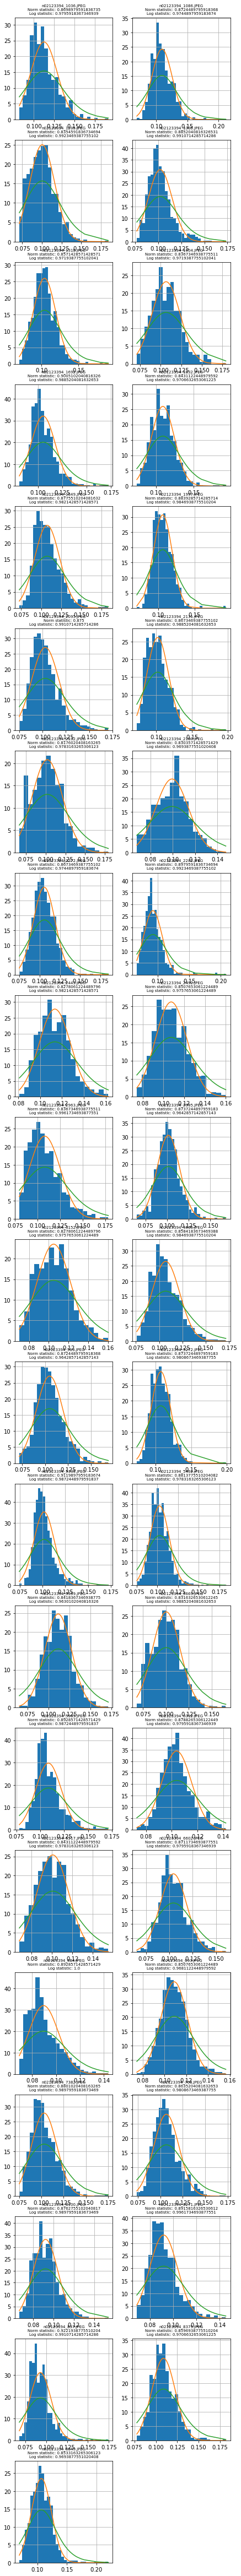

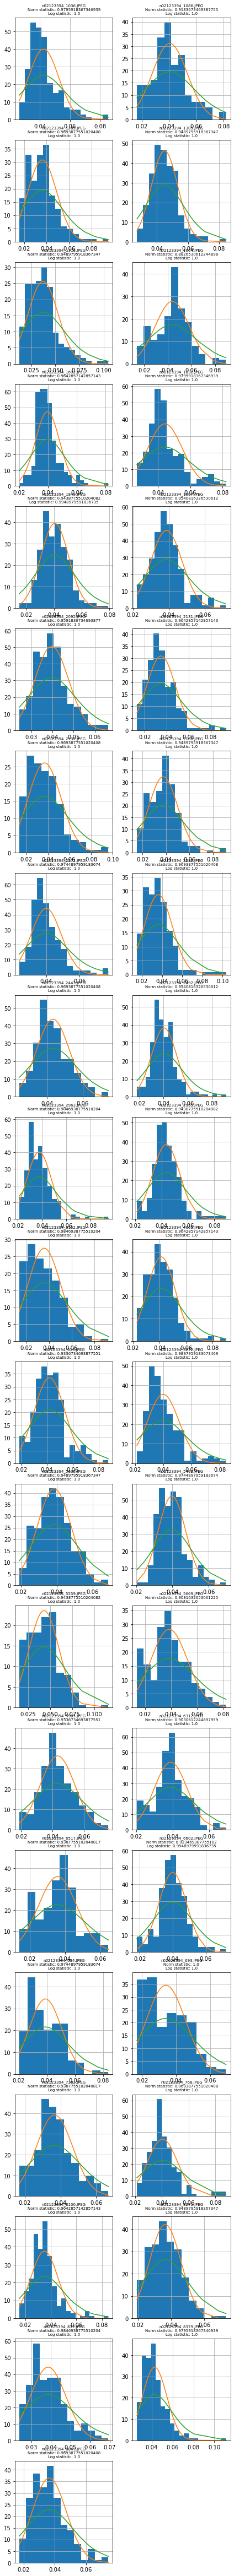

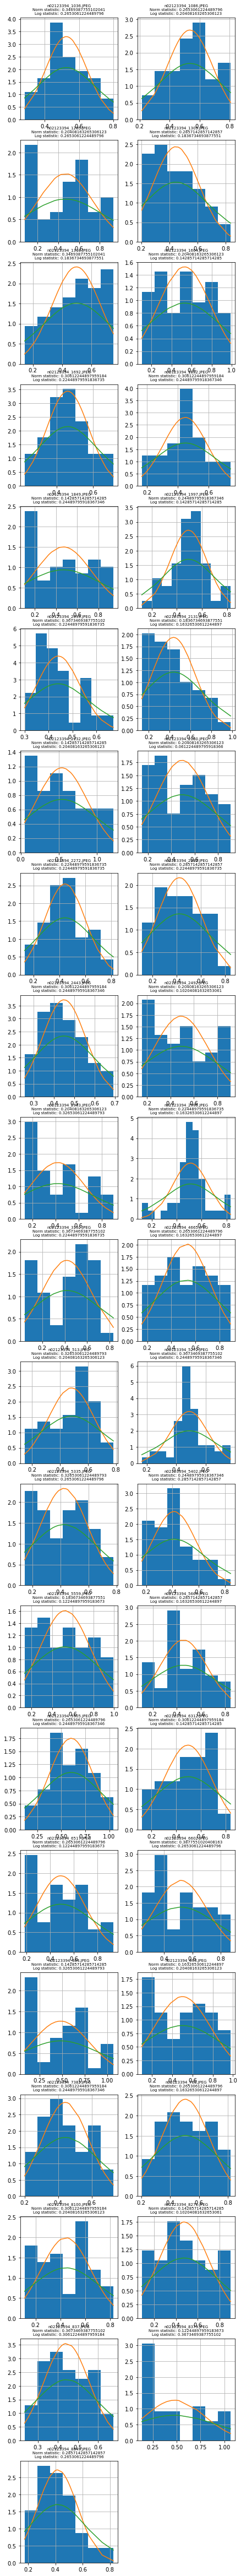

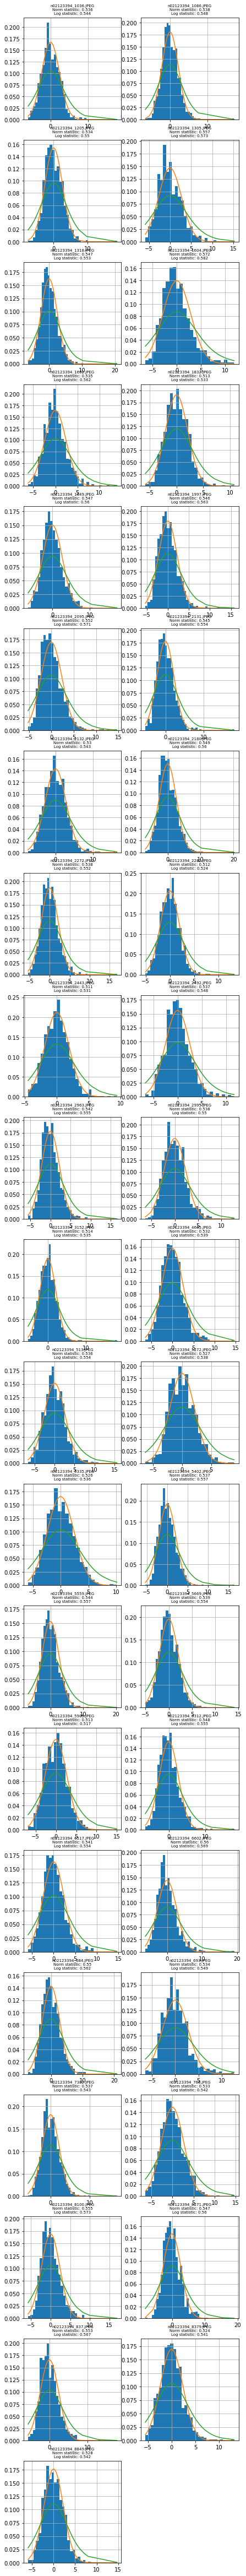

In [9]:
statistical_data_for_layers(model, preproc_list, layers_to_search)